# Simple DAO contract

In [8]:
from collections import defaultdict

class DAO(object):
    def __init__(self, target, type, da=10):
        """
        Parameters
        ----------
        target: str
                A target object to improve
        type:   str, ['doi', 'url']
                A type of target
        da:     int
                The discretization of the authorship histogram
        """
        self.target = target
        self.type = type
        self._reputation = {}
        self._authorship = {}
        self.rating = {}
        self._author_log = [] # author transactions
        self._rating_log = [] # rating transactions
        self._da = da

    @property
    def url(self):
        if self.type == 'doi':
            return 'http://doi.og/{}'.format(self.target)
        if self.type == 'url':
            return self.target
        
    def reputation(self, user_id):
        if not user_id in self._reputation:
            # Add the user and creates a prior reputation
            self.add_new_user(user_id)
        return self._reputation[user_id]
    
    def _normalize(self, dic):
        sc = sum(dic.values())
        for i in dic.keys():
            dic[i] /= sc
        
    def add_new_user(self, user_id):
        # TODO: ask if other existing users know this user
        # -> Use that information to calculate the reputation of the new user
        
        # else: Algorithm for generating prior reputation
        # Should we have an algorithm to incentivize first commers in term of reputation?
        for i in self._reputation:
            self._reputation[i] -= 1.0 / len(self._reputation)
        # TODO: formalize the function to favour first commers
        self._reputation[user_id] = -0.1 / (len(self._reputation)+4)
        
        for i in self._reputation:
            self._reputation[i] += 1.0 / len(self._reputation)
        self._normalize(self._reputation)
        
    def authorship(self, author_id):
        if not author_id in self._authorship:
            self.add_new_author(author_id)
        return self._authorship[author_id]
        
    def add_new_author(self, author_id):
        self._authorship[author_id] = np.ones([self._da]) / self._da
    
    def add_author(self, user_id, author_id, percentage):
        # register the transaction
        self._author_log.append({
            'user_id': user_id,
            'author_id': author_id,
            'percentage': percentage})

        # get the user reputation
        rep = self.reputation(user_id)
        
        # calculate the new authorship percentage
        # -> Bayes update using the existing likelihood function of the authorship 
        #    percentage multiplied with the reputation of the user and with the 
        #    prior authorship percentage
        ind = int(np.floor(percentage*self._da))
        assert percentage >= 0. and percentage <= 1.0, "percentage value should be between [0.0, 1.0], instead percentage={}".format(percentage)
        if percentage == 1.0: 
            # we put it in the last box
            ind = self._da -1
        prior = np.mean(self.authorship(author_id) * np.arange(self._da)/self._da)
        for i, hyp in enumerate(np.arange(self._da)/self._da):
            likelihood = self.authorship(author_id)[i] * self.reputation(user_id) * (hyp-percentage)
        
        print(likelihood)

For each author and user there is a joint probability distribution

### Deploy the DAO and give it a target

In [9]:
dao = DAO('10.5194/wes-2015-5-RC2', type='doi')
dao.url

'http://doi.og/10.5194/wes-2015-5-RC2'

In [10]:
dao = DAO('http://doi.og/10.5194/wes-2015-5-RC2', type='url')
dao.url

'http://doi.og/10.5194/wes-2015-5-RC2'

## Register authorship
Any reviewer can come and give its opinion about how much an ethereum account is an author of a specific article. The DAO, will consider this as a prediction market. So for each author key, it will estimate the probability of authorship.

In [11]:
from numpy.random import random
import numpy as np

In [12]:
for i in range (10):
    dao.add_author('user_%d'%(i), 'author%d'%(np.floor(random()*10)), 0.2)

0.0045
0.0045
0.0045
0.0045
0.0045
0.0045
0.0045
0.0045
0.0045
0.0045


In [6]:
dao._reputation

{'user_0': 0.1300443746871703,
 'user_1': 0.10770935056933077,
 'user_2': 0.10063659293201493,
 'user_3': 0.09742283112839248,
 'user_4': 0.09569326269826726,
 'user_5': 0.09466192744919266,
 'user_6': 0.0940023640018082,
 'user_7': 0.09355840574856877,
 'user_8': 0.09324763497130122,
 'user_9': 0.09302325581395349}

In [9]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

In [13]:
order = np.argsort(list(dao._reputation.values()))[::-1]
strip = lambda x: np.array(list(x))[order]
iplot({'data':[{'x':strip(dao._reputation.keys()),
                'y':strip(dao._reputation.values())}],
       'layout':{'xaxis':{'title':'User names'},
                 'yaxis':{'title':'Reputation [-]'}}})

## Prediction market

In [4]:
import numpy as np
from scipy.optimize import fmin_cobyla
import pandas as pd

In [8]:
class LS_LMSRMarket(object):
    def __init__(self, possible_outcomes, vig=0.1, init=1.0, market='LS_LMSR', b=None):
        """
        Parameters
        ----------
        possible_outcomes:  list
                List of strings describing the possible outcomes of the task
                                    
        vig     float
                parameter of the `alpha` variable used to calculate the `b` variable.
                Corresponds to the market "vig" value - typically between 5 and 30 percent in real-world markets
                
        init    float
                The initial subsidies of the market, spread equally in this algorithm on all the outcomes.
        
        market  srt, 'LS_LMSR' | 'LMSR'
                The market type. If 'LMSR' is selected, then a b value should be given.
        """
        self.market = market
        if self.market == 'LSMR':
            if b == None:
                raise Exception('b value is needed for LSMR markets')
            self._b = b

        self.possible_outcomes = possible_outcomes
        self.init = init
        self.vig = vig
        self._x = [np.ones([self.n])*init/self.n]
        self._book = []
        self.market_value = init
        self._history = []
        
    @property
    def alpha(self):
        return self.vig*self.n/np.log(self.n)
        
    @property
    def n(self):
        return len(self.possible_outcomes)
        
    @property
    def b(self):
        if self.market == 'LMSR':
            return self._b
        elif self.market == 'LS_LMSR':
            return self._b_func(self.x)
        else:
            raise Exception('market must be set to either "LMSR" or "LS_LMSR"')
    
    def _b_func(self, x):
        """Calculate the `b` equation: b=\alpha \Sigma x"""
        return self.alpha * x.sum()
        
    @property
    def book(self):
        return pd.DataFrame(self._book)
    
    @property
    def x(self):
        return self._x[-1].copy()
    
    def cost(self, x):
        return self.b*np.log(np.exp(x/self.b).sum())
    
    def _new_x(self, shares, outcome):
        new_x = self.x
        new_x[outcome] += shares        
        return new_x
            
    def price(self, shares, outcome):
        return self._price(self._new_x(shares, outcome))
        
    def _price(self, x):
        return self.cost(x)-self.cost(self.x)
    
    def register_x(self, x):
        self._x.append(x)
        
    def calculate_shares(self, paid, outcome):
        obj_func = lambda s: np.abs(self.price(s, outcome) - paid)
        return fmin_cobyla(obj_func, paid/self.p[outcome], [])
    
    def buy_shares(self, name, paid, outcome):
        shares = self.calculate_shares(paid, outcome)
        self.register_x(self._new_x(shares, outcome))
        self._book.append({'name':name, 
                           'shares':shares, 
                           'outcome':outcome, 
                           'paid':paid})
        self._history.append(self.p)
        self.market_value += paid
        print("%s paid %2.2f EUR, for %2.2f shares of outcome %d, which will give him %2.2f EUR if he wins"%(
                name, paid, shares, outcome, shares/self.x[outcome]*self.market_value))
        return shares
    
    def sell_shares(self, name, shares, outcome):
        price = self.price(-share, outcome)
        self._book.append({'name':name, 
                           'shares':-shares, 
                           'outcome':outcome, 
                           'paid':-price}) 
        self.market_value -= price        
        self._history.append(self.p)        
        return price

    def outcome_probability(self):
        K = np.exp(self.x/self.b)
        return K/K.sum()
    
    def add_outcome(self, new_outcome):
        new_x = self.x - np.ones([self.n])*self.init/self.n
        new_x = np.array(new_x.tolist() + [0.])
        new_x += np.ones([self.n + 1]) * self.init/(self.n + 1)
        self.register_x(new_x)
        self.possible_outcomes.append(new_outcome)

    
    @property
    def p(self):
        return self.outcome_probability()
    
    def history(self):
        return np.array(self._history)

In [9]:
ls = LS_LMSRMarket(['author1'])

In [10]:
ls.p

array([ 1.])

In [ ]:
ls.buy_shares('bob', 10, 0)

In [ ]:
ls.p

In [107]:
ls.add_outcome('author2', )

In [108]:
ls.init

1.0

In [109]:
ls.p

array([ 0.33333333,  0.33333333,  0.33333333])

In [110]:
ls.x

array([ 0.33333333,  0.33333333,  0.33333333])

## Updating the belief of authorship
**Scenario:** A reviewer $r_j$ with a reputation $R(r_j)$ is telling the DAO that an author $a_i$ has an authorship percentage $A(a_i|r_j)$.

$A$ is a space of $\mathbb{N} \times \mathbb{N}\rightarrow[0,1]$. Given a list of author addresses it will return a percentage of authorship: e.g. $A(a_x|r_y) = 0.3$

Furthermore $A$ has the following properties that should be enforced:
- $\sum_{i=1\in\mathbb{N}}A(a_i|r_j)<=1.0$. Given a reviewer, the sum of the authorship he proposes cannot be larger than 1.0



The belief of authorship $B_A$ is a function $\mathbb{N} \rightarrow [0,1] \rightarrow \mathbb{R}$. For a given author it gives the current PDF of the belief its authorship percentage. 

In [1]:
import numpy as np

/Users/pe/.virtualenvs/DAO/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/pe/.virtualenvs/DAO/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Frequentists: 0.426993562569
Bayesian: 0.425425425425


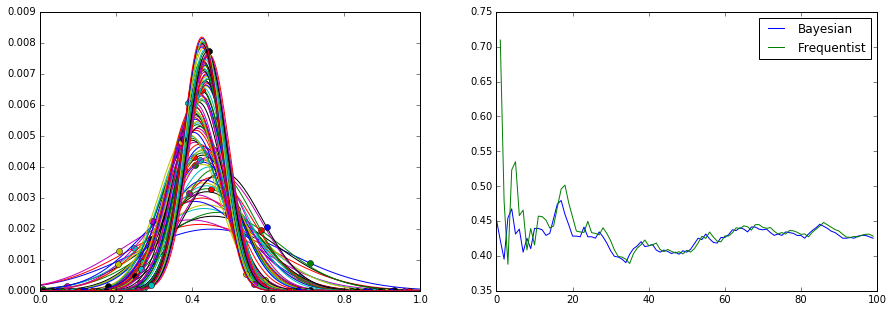

In [113]:
# discretization of the authorship percentage interval
n = 1000
# The different values of the PMF
id_a = np.linspace(0,1,n)
# Uniform prior PMF
authorship = np.ones([n])/n
# Uniform prior PMF
authorship = np.exp(-(0.4-id_a)**2/(2*0.05))

fig = pl.figure(figsize=(15,5))
ax = pl.subplot(1,2,1)
m = 100
vals = np.random.random(m)
maxli = np.zeros([m])
freq = np.zeros([m])
for i, a in enumerate(vals):
    for b in range(n):
        if a < 0 or a > 1:
            likelihood = 0.0
        else:
            sig = 0.25
            likelihood = np.exp(-abs(id_a[b] - a)**2/(2*sig))
        if likelihood < 0:
            likelihood = 0.0
        if likelihood > 1.0:
            likelihood = 1.0
        authorship[b] *= likelihood
    # normalize
    authorship /= authorship.sum()

    maxli[i] = id_a[np.argmax(authorship)]
    freq[i] = vals[:i].mean()
    pl.plot(id_a, authorship)
    pl.plot(a, authorship[int(np.floor(a*n))],'o')
    
ax = pl.subplot(1,2,2)
pl.plot(range(m), maxli, label='Bayesian')
pl.plot(range(m), freq, label='Frequentist')
pl.legend()
print('Frequentists:', vals.mean())
print('Bayesian:', id_a[np.argmax(authorship)])

And now adding the reputation of the reviewer as part of the likelihood function

Frequentists: 0.490448403676
Bayesian: 0.479479479479


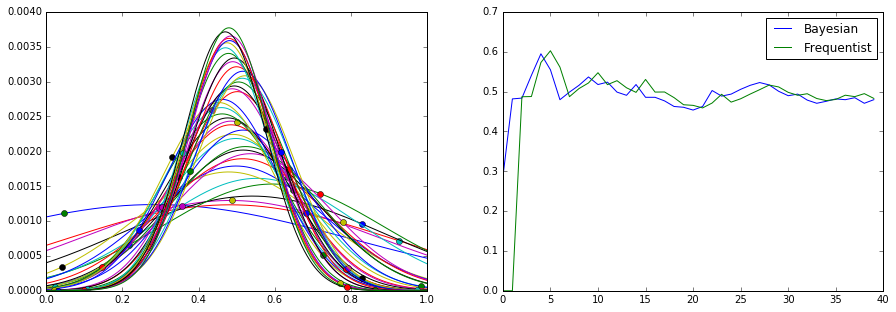

In [138]:
# discretization of the authorship percentage interval
n = 1000
# The different values of the PMF
id_a = np.linspace(0,1,n)
# Uniform prior PMF
#authorship = np.ones([n])/n
# Uniform prior PMF
authorship = np.exp(-(0.5-id_a)**2/(2*0.5))

fig = pl.figure(figsize=(15,5))
ax = pl.subplot(1,2,1)
m = 40
vals = np.random.random(m)
maxli = np.zeros([m])
freq = np.zeros([m])
for i, a in enumerate(vals):
    reviewer_reputation = min(max(0.25 + np.random.random(1)/2.0,0.0), 1.0)
    for b in range(n):
        if a < 0 or a > 1:
            likelihood = 0.0
        else:
            sig = 0.05
            # The reviewer reputation is inversely proportional to the sigma of the normal likelihood function
            likelihood = np.exp(-abs(id_a[b] - a)**2/(2*(1-reviewer_reputation+1.E-4)))
        if likelihood < 0:
            likelihood = 0.0
        if likelihood > 1.0:
            likelihood = 1.0
        authorship[b] *= likelihood
    # normalize
    authorship /= authorship.sum()

    maxli[i] = id_a[np.argmax(authorship)]
    if i > 1:
        freq[i] = vals[:i].mean()
    pl.plot(id_a, authorship)
    pl.plot(a, authorship[int(np.floor(a*n))],'o')
    
ax = pl.subplot(1,2,2)
pl.plot(range(m), maxli, label='Bayesian')
pl.plot(range(m), freq, label='Frequentist')
pl.legend()
print('Frequentists:', vals.mean())
print('Bayesian:', id_a[np.argmax(authorship)])

In [136]:
vals

array([ 0.8666793 ,  0.21471583,  0.06904912,  0.99748794,  0.29729262,
        0.297464  ,  0.71717202,  0.43436442,  0.3491234 ,  0.36463484,
        0.68062284,  0.14917839,  0.40400435,  0.04788948,  0.05530381,
        0.52771366,  0.70102584,  0.2907972 ,  0.30941309,  0.29637728,
        0.9850325 ,  0.73350953,  0.41459816,  0.54328585,  0.37824168,
        0.51799425,  0.51829936,  0.64718275,  0.65175711,  0.35823344,
        0.08500089,  0.67391915,  0.76884108,  0.36387042,  0.29171737,
        0.47449711,  0.80056415,  0.60367592,  0.87818001,  0.71392898])

In [96]:
import matplotlib.pylab as pl
%matplotlib inline

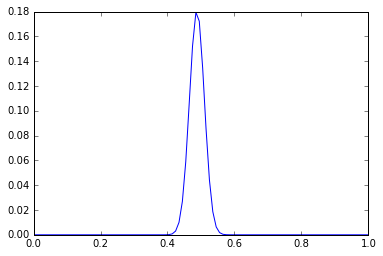

In [97]:
pl.plot(id_a, authorship)

In [52]:
id_a[np.argmax(authorship)]

0.50505050505050508